In [1]:
# 模型源码：https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/nets/inception_v3.py
# 官网例子：https://github.com/tensorflow/models/blob/master/tutorials/image/imagenet/classify_image.py
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image 
import matplotlib.pyplot as plt

images/husky.jpg


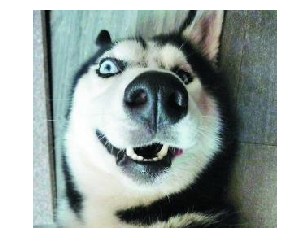

Siberian husky (score = 0.52208)
Eskimo dog, husky (score = 0.35693)
malamute, malemute, Alaskan malamute (score = 0.01076)
kelpie (score = 0.00283)
dogsled, dog sled, dog sleigh (score = 0.00140)

images/cat.jpg


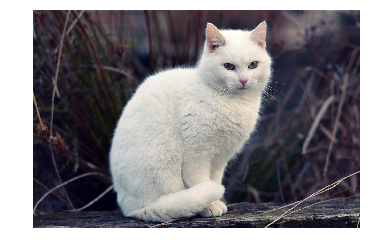

Egyptian cat (score = 0.18538)
Arctic fox, white fox, Alopex lagopus (score = 0.15414)
Siamese cat, Siamese (score = 0.10329)
lynx, catamount (score = 0.04546)
Angora, Angora rabbit (score = 0.02674)

images/plane.jpg


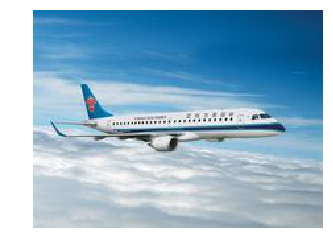

airliner (score = 0.86965)
wing (score = 0.04838)
space shuttle (score = 0.00092)
revolver, six-gun, six-shooter (score = 0.00053)
warplane, military plane (score = 0.00045)

images/flower.jpg


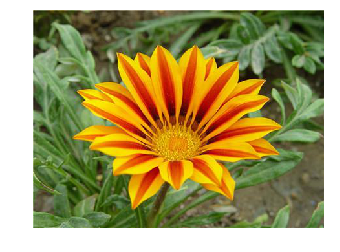

daisy (score = 0.97638)
pinwheel (score = 0.00125)
pot, flowerpot (score = 0.00095)
bee (score = 0.00089)
sulphur butterfly, sulfur butterfly (score = 0.00053)

images/car.jpg


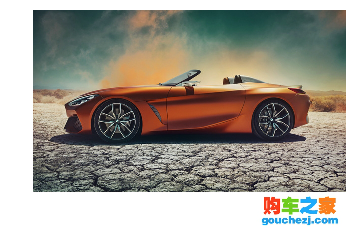

sports car, sport car (score = 0.60130)
convertible (score = 0.19217)
car wheel (score = 0.02569)
grille, radiator grille (score = 0.00272)
racer, race car, racing car (score = 0.00238)

images/seaside.jpg


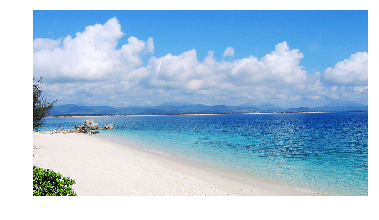

sandbar, sand bar (score = 0.97206)
seashore, coast, seacoast, sea-coast (score = 0.01291)
lakeside, lakeshore (score = 0.00316)
catamaran (score = 0.00052)
coral reef (score = 0.00033)



In [2]:
class NodeLookup(object):
    def __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path,uid_lookup_path)
    
    def load(self,label_lookup_path,uid_lookup_path):
        if not tf.gfile.Exists(uid_lookup_path):
            # 预先检测地址是否存在
            tf.logging.fatal('File does not exist {}'.format(uid_lookup_path))
        if not tf.gfile.Exists(label_lookup_path):
            # 预先检测地址是否存在
            tf.logging.fatal('File does not exist {}'.format(label_lookup_path))
        
        # 加载份额类字符串n********对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}

# ==============================================================================
#         # 使用正则化方法处理文件：
#         p = re.compile(r'[n\d]*[ \S,]*')
#         for line in proto_as_ascii_lines:         
#              = p.findall(line)
#             uid = parsed_items[0]
#             human_string = parsed_items[2]
#             uid_to_human[uid] = human_string
# ==============================================================================

        # 按行读取数据
        for line in proto_as_ascii_lines :
            # 去掉换行符
            line = line.strip('\n')
            # 按照'\t'分割
            parsed_items = line.split('\t')
            # 按照分类编号
            uid = parsed_items[0]
            # 获取分类名称
            human_string = parsed_items[1]
            # 编号的字符串和名称的映射
            uid_to_human[uid] = human_string
        
        # 加载分类字符串n********对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii :
            if line.startswith('  target_class:'):
                # 获取编号
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                # 获取编号的字符串
                target_class_string = line.split(': ')[1]
                # 编号和字符串的映射
                node_id_to_uid[target_class] = target_class_string[1:-2]
            
        # 建立编号和名称的映射
        node_id_to_name = {}
        for key,val in node_id_to_uid.items():
            # 假如uid不存在于uid_to_human中，则报错
            if val not in uid_to_human:
                tf.logging.fatal('Failed to locate: {}'.format(val))
            else:
                # 获取分类名称
                name = uid_to_human[val]
                # 建立编号和名称的映射关系
                node_id_to_name[key] = name
        return node_id_to_name
    
    # 传入分类编号1-1000返回分类名称
    def id_to_string(self,node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]
    
# 创建一个图来存放google训练好的模型
# tf.gfile.FastGFile(path,decodestyle) 
# 函数功能：实现对图片的读取。 
# 函数参数：(1)path：图片所在路径 (2)decodestyle:图片的解码方式。(‘r’:UTF-8编码; ‘rb’:非UTF-8编码)
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb','rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def,name='')

# 创建会话，因为是从已有的Inception_v3模型中恢复，所以无需初始化
with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
    # Inception_v3模型的最后一层softmax的输出
    # 形如'conv1'是节点名称，而'conv1:0'是张量名称，表示节点的第一个输出张量
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    # 遍历目录
    for root,dirs,files in os.walk('images/'):
        for file in files:
            # 载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root,file),'rb').read()
            prediction = sess.run(softmax_tensor,{'DecodeJpeg/contents:0': image_data}) # jpg格式
            prediction = np.squeeze(prediction) # 降为一维
            
            # 打印图片路径以及名称
            image_path = os.path.join(root,file)
            print(image_path)
            # 显示图片
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            
            # 排序
            top_k = prediction.argsort()[-5:][::-1]
            node_lookup = NodeLookup()
            for node_id in top_k:
                # 获取分类名称
                human_string = node_lookup.id_to_string(node_id)
                # 获取该分类的置信度
                score = prediction[node_id]
                print('%s (score = %.5f)' % (human_string,score))
            print()

        

In [ ]:
images/husky.jpg

Siberian husky (score = 0.52208)
Eskimo dog, husky (score = 0.35693)
malamute, malemute, Alaskan malamute (score = 0.01076)
kelpie (score = 0.00283)
dogsled, dog sled, dog sleigh (score = 0.00140)

images/cat.jpg

Egyptian cat (score = 0.18538)
Arctic fox, white fox, Alopex lagopus (score = 0.15414)
Siamese cat, Siamese (score = 0.10329)
lynx, catamount (score = 0.04546)
Angora, Angora rabbit (score = 0.02674)

images/plane.jpg

airliner (score = 0.86965)
wing (score = 0.04838)
space shuttle (score = 0.00092)
revolver, six-gun, six-shooter (score = 0.00053)
warplane, military plane (score = 0.00045)

images/flower.jpg

daisy (score = 0.97638)
pinwheel (score = 0.00125)
pot, flowerpot (score = 0.00095)
bee (score = 0.00089)
sulphur butterfly, sulfur butterfly (score = 0.00053)

images/car.jpg

sports car, sport car (score = 0.60130)
convertible (score = 0.19217)
car wheel (score = 0.02569)
grille, radiator grille (score = 0.00272)
racer, race car, racing car (score = 0.00238)

images/seaside.jpg

sandbar, sand bar (score = 0.97206)
seashore, coast, seacoast, sea-coast (score = 0.01291)
lakeside, lakeshore (score = 0.00316)
catamaran (score = 0.00052)
coral reef (score = 0.00033)


1
​